In [51]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.stattools import durbin_watson
import math
plt.style.use('fivethirtyeight')

In [28]:
foo =r'C:\Users\ACER\Desktop\python project\airqo/BugolobiHOULY.csv'

In [29]:
import warnings
warnings.filterwarnings('ignore')

In [154]:
pjme = pd.read_csv(foo, index_col=[0], parse_dates=[0])

# Basic EDA¶

In [155]:
pjme.head(5)

,s2_pm2_5
Date,
2019-03-12 09:00:00,19.975000
2019-03-12 11:00:00,15.408571
2019-03-12 12:00:00,14.654348
2019-03-12 13:00:00,14.365435
2019-03-12 14:00:00,15.451739


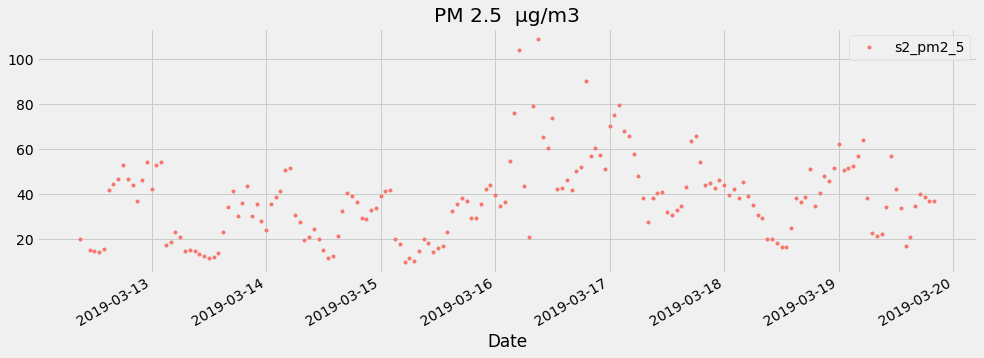

In [157]:
# Plotting timeseries
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
temp_plot = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PM 2.5  µg/m3')

In [158]:
split_date = '18-03-2019'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

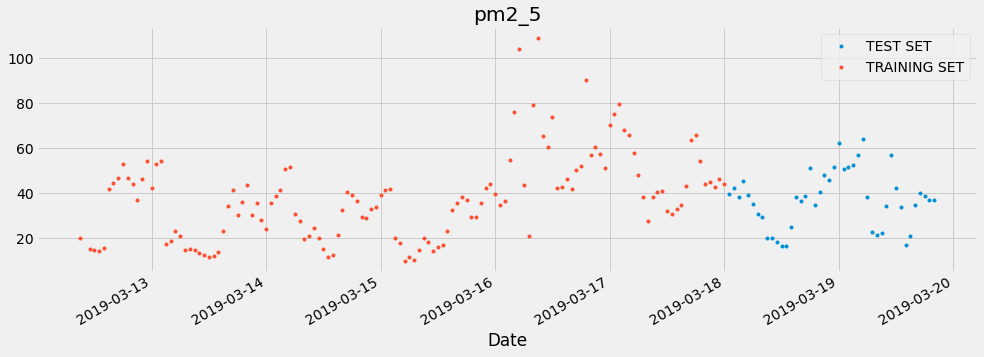

In [160]:
temp_plot = pjme_test \
    .rename(columns={'s2_pm2_5': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'s2_pm2_5': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='pm2_5', style='.')

In [75]:
def create_lagged_features(df, lag_count):
    """Creates lagged features"""
    # lag_count should be the number of lags to create
    
    for i in range(0, lag_count):
        df['t-{}'.format(i+1)] = df['s2_pm2_5'].shift(i+1)

    return df

In [76]:
def create_features(df, lag_count, label=None):
    """Creates time series from a datetime index"""
    # Date Features
    df['Date'] = df.index
    df['hour'] = df['Date'].dt.hour
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    # Lagged Features
    
    df = create_lagged_features(df, lag_count)
    
    column_set = ['hour','dayofweek','quarter','month','year',
                   'dayofyear','dayofmonth','weekofyear']
    
    for i in range(0, lag_count):
        column_set.append('t-{}'.format(i+1))
    
    X = df[column_set]
    
    if label:
        y = df[label]
        # Drop first N (not enough lagged variables)
        X = X[lag_count:]
        y = y[lag_count:]
        return X, y
    
    # Drop first N (not enough lagged variables)
    X = X[lag_count:]
    
    return X

In [77]:
lag_count = 2

X_train, y_train = create_features(pjme_train, lag_count, label='s2_pm2_5')
X_test, y_test = create_features(pjme_test, lag_count, label='s2_pm2_5')

In [78]:
print("s2_pm2_5: ", pjme.shape)
print("X_train SHAPE: ", X_train.shape)
print("X_test SHAPE: ", X_test.shape)
print("Dif in rows (expecting lag_count*2): ", pjme.shape[0]-(X_train.shape[0]+X_test.shape[0]))

s2_pm2_5:  (179, 1)
X_train SHAPE:  (133, 10)
X_test SHAPE:  (42, 10)
Dif in rows (expecting lag_count*2):  4


In [79]:
start = datetime.datetime.now()
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train
end = datetime.datetime.now()
print("Total runtime for XGBoost: ", end-start)

[0]	validation_0-rmse:30.96800	validation_1-rmse:29.68014
[1]	validation_0-rmse:23.17694	validation_1-rmse:22.30532
[2]	validation_0-rmse:17.82564	validation_1-rmse:17.29507
[3]	validation_0-rmse:13.85219	validation_1-rmse:14.82394
[4]	validation_0-rmse:10.93060	validation_1-rmse:13.76353
[5]	validation_0-rmse:8.62957	validation_1-rmse:12.99727
[6]	validation_0-rmse:7.02500	validation_1-rmse:12.62479
[7]	validation_0-rmse:5.68217	validation_1-rmse:12.42168
[8]	validation_0-rmse:4.67561	validation_1-rmse:12.06261
[9]	validation_0-rmse:3.86011	validation_1-rmse:11.85048
[10]	validation_0-rmse:3.17916	validation_1-rmse:11.88918
[11]	validation_0-rmse:2.70520	validation_1-rmse:11.94326
[12]	validation_0-rmse:2.33093	validation_1-rmse:11.86663
[13]	validation_0-rmse:2.00734	validation_1-rmse:11.90858
[14]	validation_0-rmse:1.72892	validation_1-rmse:11.90407
[15]	validation_0-rmse:1.54243	validation_1-rmse:11.96010
[16]	validation_0-rmse:1.40269	validation_1-rmse:11.94629
[17]	validation_0-r

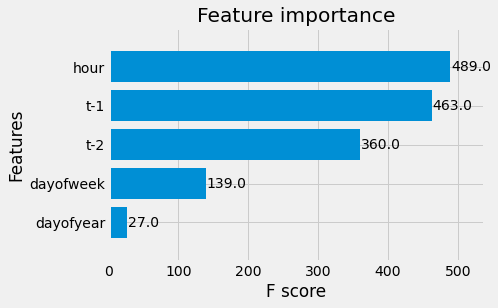

In [80]:
plot_importance(reg, height=.8)

In [81]:
# Drop first ten rows of test set because X currently drops 10 rows **FIX THIS**
pjme_test = pjme_test[lag_count:]

In [85]:
pjme_test['s2_pm2_5_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

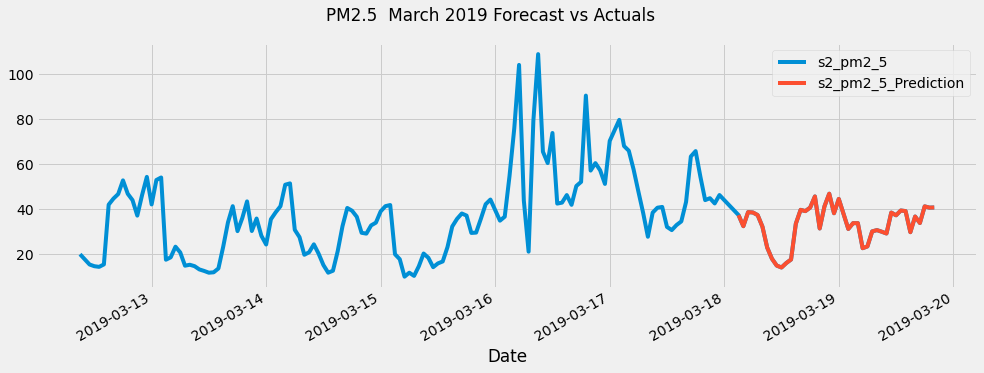

In [161]:
temp_plot = pjme_all[['s2_pm2_5','s2_pm2_5_Prediction']].plot(figsize=(15, 5))
plot = plt.suptitle('PM2.5  March 2019 Forecast vs Actuals')

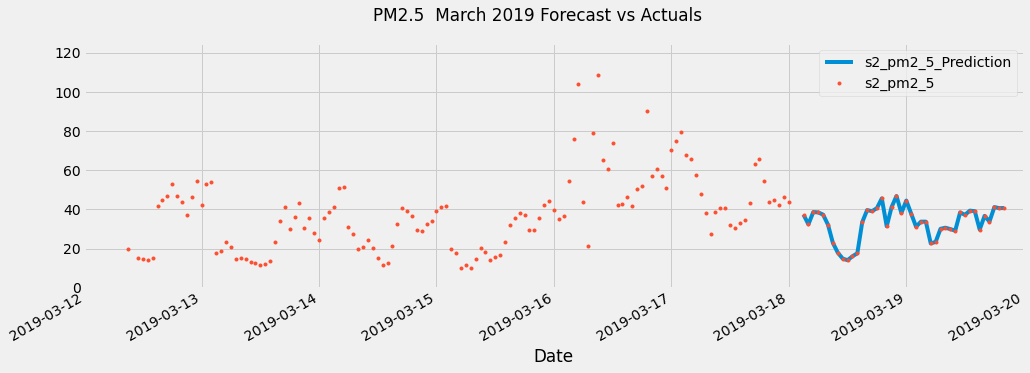

In [127]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_chart = pjme_all[['s2_pm2_5_Prediction','s2_pm2_5']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='03-12-2019', upper='03-20-2019')
ax.set_ylim(0, 125)
plot = plt.suptitle('PM2.5  March 2019 Forecast vs Actuals')

In [ ]:
plt.xlim(X_.min(), X_.max())
#plt.xlim(329.0, 344.5)
#plt.ylim(0,40.5)


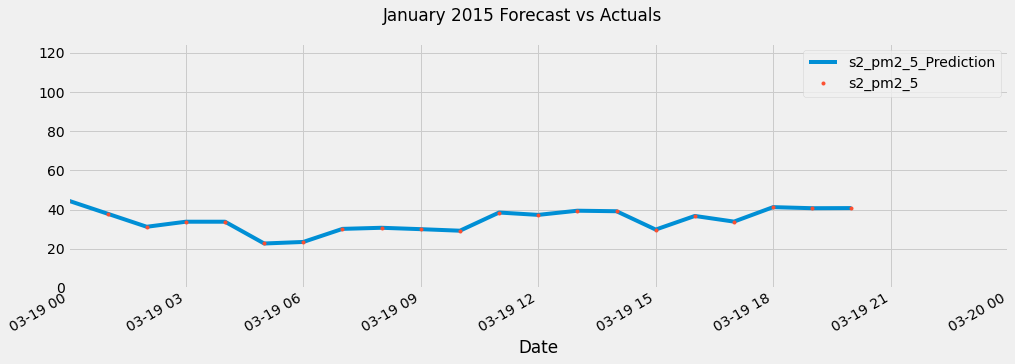

In [134]:
# Plot the forecast against the actual observations
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
temp_chart = pjme_all[['s2_pm2_5_Prediction','s2_pm2_5']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='03-19-2019', upper='03-20-2019')
ax.set_ylim(0, 125)
#plt.xlim(lower='03-12-2019', upper='03-20-2019')
plt.legend(loc=1)
#plt.legend()

plot = plt.suptitle('January 2015 Forecast vs Actuals')

# Nested Cross-Validation

K-Fold Cross Validation is the gold standard for validating ML algorithms. However, K-Fold Cross Validation does not work with time-series, as it fails to capture temporal dependencies. Instead, we'll use nested cross validation.

In [162]:
start_dates = [
    '12-03-2019'
]

split_dates = [
    '15-03-2019'
]

end_dates = [
    '22-03-2019'
   
]

start date:  12-03-2019
split date:  15-03-2019
end date:  22-03-2019 



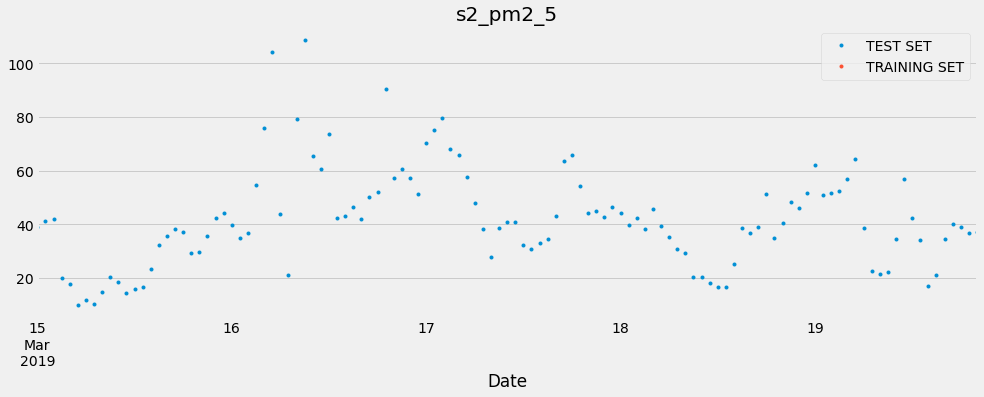

In [163]:
for i in range(0, len(split_dates)):
    print('start date: ', start_dates[i])
    print('split date: ', split_dates[i])
    print('end date: ', end_dates[i], '\n')
    temp_pjme_train = pjme.loc[pjme.index <= split_dates[i]].copy()
    temp_pjme_test = pjme.loc[pjme.index >= split_dates[i]].copy()
    nested_pjme_train = temp_pjme_train[temp_pjme_train.index >= start_dates[i]].copy()
    nested_pjme_test = temp_pjme_test[temp_pjme_test.index <= end_dates[i]].copy()
    
    temp_plot = nested_pjme_test \
    .rename(columns={'s2_pm2_5': 'TEST SET'}) \
    .join(nested_pjme_train.rename(columns={'s2_pm2_5': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='s2_pm2_5', style='.')

In [164]:
def nested_cross_validation(start_dates, split_dates, end_dates, pjme, lag_count):
    # Because the data is a time-series, k-fold cross-validation is not sufficient.
    # Instead, we will use nested cross-validation
    
    for i in range(0, len(split_dates)):
        temp_start_date = start_dates[i]
        temp_split_date = split_dates[i]
        temp_end_date = end_dates[i]
        
        print('start date: ', temp_start_date)
        print('split date: ', temp_split_date)
        print('end date: ', temp_end_date, '\n')
        
        nested_pjme_train, nested_pjme_test = get_nested_train_test(temp_start_date, temp_split_date, temp_end_date, pjme)
        
        X_train, y_train = create_features(nested_pjme_train, lag_count, label='s2_pm2_5')
        X_test, y_test = create_features(nested_pjme_test, lag_count, label='s2_pm2_5')
        
        nested_pjme_test = nested_pjme_test[lag_count:]
    
        reg = train_model(X_train, y_train, X_test, y_test)
        
        nested_pjme_test['s2_pm2_5_Prediction'] = reg.predict(X_test)
        
        # Evaluate
        print("MSE: ", mean_squared_error(y_true=nested_pjme_test['s2_pm2_5'], y_pred=nested_pjme_test['s2_pm2_5_Prediction']))
        print("RMSE: ", math.sqrt(mean_squared_error(y_true=nested_pjme_test['s2_pm2_5'], y_pred=nested_pjme_test['s2_pm2_5_Prediction'])))
        print("MAE: ", mean_absolute_error(y_true=nested_pjme_test['s2_pm2_5'], y_pred=nested_pjme_test['s2_pm2_5_Prediction']))
        print("Mean Absolute Percentage Error: {}%".format(round(mean_absolute_percentage_error(nested_pjme_test['s2_pm2_5'], nested_pjme_test['s2_pm2_5_Prediction']), 4)))
        print("\n")
        print("================")
     

In [165]:
def get_nested_train_test(start_date, split_date, end_date, pjme):
    temp_pjme_train = pjme.loc[pjme.index <= split_date].copy()
    temp_pjme_test = pjme.loc[pjme.index >= split_date].copy()
    nested_pjme_train = temp_pjme_train[temp_pjme_train.index >= start_date].copy()
    nested_pjme_test = temp_pjme_test[temp_pjme_test.index <= end_date].copy()
    
    return nested_pjme_train, nested_pjme_test

In [166]:
def train_model(X_train, y_train, X_test, y_test):
    start = datetime.datetime.now()
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=50,
           verbose=False) # Change verbose to True if you want to see it train
    end = datetime.datetime.now()
    print("Total runtime for XGBoost: ", end-start)
    
    return reg

In [167]:
nested_cross_validation(start_dates, split_dates, end_dates, pjme, lag_count)

start date:  12-03-2019
split date:  15-03-2019
end date:  22-03-2019 

[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Us

[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1264: Empty dataset at worker: 0
[22:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1

Text(0, 0.5, ' µg/m3')

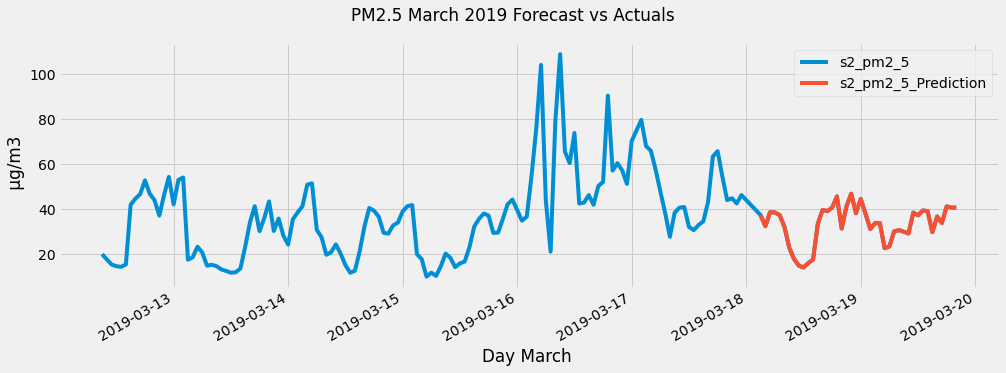

In [168]:
temp_plot = pjme_all[['s2_pm2_5','s2_pm2_5_Prediction']].plot(figsize=(15, 5))

plot = plt.suptitle('PM2.5 March 2019 Forecast vs Actuals')

plt.xlabel("Day March ")
plt.ylabel(" µg/m3")